## Project Introduction

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg">

For my final project I chose a **Kaggle Challenge**, which is "**Santander Customer Transaction Prediction**". This is one of the most popular kaggle challenges as it has most number of teams (**8,751**) that participated. Well, I am going to come up with a solution that comes on **top 1%** of the solutions on **Kaggle Leaderboard**, so lets get started!

**Santander** is always looking for ways to help their customers understand their financial health and identify which products and services might help them achieve their monetary goals.

In this Kaggle competition, they are inviting Kagglers to help them **identify which customers will make a specific transaction** in the future, irrespective of the amount of money transacted. Along with **binary target column**, we have **200 feature columns** and we don't know what they actually mean! They are kind of a blackbox that we don't know anything about. So **Feature Engineering** is kind of inevitable in this case and also pretty challenging!

The data provided for this competition has the same structure as the real data we have available to solve this problem.

### 1. Understanding the Problem:
Our goal is to create an algorithm which could figure out whether a particular customer will make a transaction or not. This is a **Supervised** problem as we are given the target values in our training data. Also, it is a **Classification** problem as we are going to predict 0 or 1 for a customer transaction. If it is 0 then customer won't make that transaction and if it is 1 then s/he will!

### 2. Understanding the Data:
We have training as well as test datasets in this project.
The **Training** set contains **200,000** entries and the **Test** set contains **200,000** entries as well.
The training data has 'target' column whose values are either 0 or 1. The test data does not have this column as that's what we are going to predict in this case!
We have **200 feature columns** with no information on what that column means in the banking/finance domain. They are just var_1, var_2, var_3 and so on. This part makes this kaggle challenge extra challenging! And looks like **Deep Learning model** will be very useful here.

### 3. Understanding the Evaluation Metric
The evaluation metric is the **Area Under ROC Curve** which is also called **AU-ROC/AOC Curve**. It is one of the most important evaluation metrics for checking any classification model’s performance.

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. **It tells how much model is capable of distinguishing between classes.** Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, higher the AUC (close to 1), better the model is at distinguishing between patients with disease and no disease. The curve is plotted with True Positive Rates Vs the False Positive Rates along the x and y axes respectively.

### 4. Submission File
Submissions are evaluated on **area under the ROC curve** between the predicted probability and the observed target.
For each Id in the test set, we need to make a **binary prediction** of the target variable. The file should contain a header and have the following format:

 `ID_code, target`   

 `test_0, 0`   
 `test_1, 1`   
 `test_2, 0`

### Step 1 : Importing Dependencies

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import TensorDataset
from torch.utils.data.dataset import random_split
from math import ceil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

### Step 2 : Loading Dataset from Kaggle

We are provided with an **Anonymized Dataset** containing numeric feature variables, the binary **target** column, and a string **ID_code** column.

The task is to predict the value of `target` column in the test set.

#### `File descriptions`
* **train.csv** - the training set.
* **test.csv** - the test set. The test set contains some rows which are not included in scoring.
* **sample_submission.csv** - a sample submission file in the correct format.

We will download the raw zip archive data by using `opendatasets` library, So lets install that first:

In [ ]:
!pip install opendatasets -q #It will do the installation in quiet mode

Make sure you key-in the kaggle credentials before downloading. Your **Kaggle key and password** will be required to proceed. You can just upload **kaggle.json** file in your root directory.

In [ ]:
import opendatasets as od

data_url = "https://www.kaggle.com/competitions/santander-customer-transaction-prediction/data"
od.download(data_url)

100%|██████████| 250M/250M [00:05<00:00, 44.5MB/s]



Extracting archive ./santander-customer-transaction-prediction/santander-customer-transaction-prediction.zip to ./santander-customer-transaction-prediction


These files and folders will be downloaded in our local instance:

In [ ]:
base_dir = 'santander-customer-transaction-prediction'
print(os.listdir(base_dir))

['test.csv', 'train.csv', 'sample_submission.csv']


In [ ]:
train_file_path = "/content/santander-customer-transaction-prediction/train.csv"
test_file_path = "/content/santander-customer-transaction-prediction/test.csv"

### Step 3 : Exploratory Data Analysis

This is going to be very critical for this project as we know nothing about the features, nothing about the customers as well. There is no way we can manually engineer the features as we know nothing about the meaning of that column. What does each column mean, we don't know. So lets start with EDA now. We will check the **Data Balancing**, and **Distribution** of target as well as some features.

Let's check the train and test set.

As we are returning both the datasets as well as the dataframes from the method `get_data()`. So we will be using the pandas dataframes for EDA. Later for model training we will be using the tensor datasets.

#### Function for Loading Data into PyTorch Dataset

In the code below I am using `TensorDataset`.
In practice, loading our data into a **PyTorch** dataset will be one of the first steps we take in order to create and train a **neural network** with PyTorch.

The **TensorDataset** class is very helpful when our dataset can be loaded directly as a `NumPy` array. Recall that `TensorDataset()` can take one or more NumPy arrays as input.

We will start with the **given input files** for train and test datasets.

In [ ]:
def get_data():
    train_data = pd.read_csv(train_file_path)
    y = train_data["target"]
    X = train_data.drop(["ID_code", "target"], axis=1)

    #Creating Tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)

    #Creating Tensor Dataset
    ds = TensorDataset(X_tensor, y_tensor)

    #Creating Train and Validation Datasets
    train_ds, val_ds = random_split(ds, [int(0.8*len(ds)), ceil(0.2*len(ds))])

    #Creating Test Dataset for training data
    test_data = pd.read_csv(test_file_path)
    test_ids = test_data["ID_code"]
    X = test_data.drop(["ID_code"], axis=1)

    #Creating Tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)

    #Creating Tensor Dataset for testing data
    test_ds = TensorDataset(X_tensor, y_tensor)

    return train_ds, val_ds, test_ds, test_ids, train_data, test_data


In [ ]:
train_ds, val_ds, test_ds, test_ids, train_df, test_df = get_data()

In [ ]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

Both train and test datasets have **200,000** entries, 202 and 201 columns respectively.

Let's take a look at train and test datasets individually.

In [ ]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


As we can see that the **Training** data contains:  

* **ID_code** (string) : This might correspond to an individual customer
* **target**
* **200** numerical variables, named from **var_0** to **var_199**

And the **Test** data contains:  

* **ID_code** (string) : This might correspond to an individual customer
* **200** numerical variables, named from **var_0** to **var_199**



#### EDA - Check Missing Values

Now let's check if there are any missing values.

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
# set the max columns to none
pd.set_option('display.max_columns', None)

In [ ]:
%%time
missing_data(train_df)

CPU times: user 277 ms, sys: 59.3 ms, total: 336 ms
Wall time: 342 ms


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,f

In [ ]:
%%time
missing_data(test_df)

CPU times: user 316 ms, sys: 71.4 ms, total: 388 ms
Wall time: 401 ms


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

There are **no missing data** in train and test datasets. So the given dataset is clean already

Let's check the numerical values in train and test dataset.

In [ ]:
%%time
train_df.describe()

CPU times: user 2.71 s, sys: 70.3 ms, total: 2.78 s
Wall time: 2.9 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2000

In [ ]:
%time
test_df.describe()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000

We can notice that:   

* The **Standard Deviation** is relatively **large** for both train and test datasets  
* **min**, **max**, **mean**, **std** values for train and test datasets looks pretty **similar**  
* **mean** values are distributed over a **large** **range** for both train and test datasets

#### EDA - Visualization : Overall Class Distribution

Let's check the distribution of target value in train dataset.

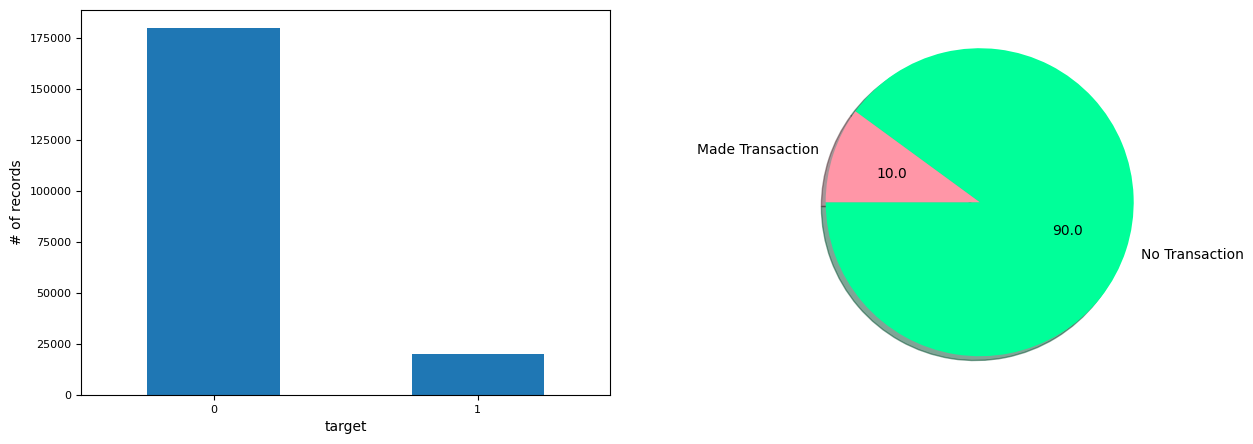

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplot(1, 2, 1)
train_df['target'].value_counts().plot.bar(ylabel = '# of records', fontsize = 8)
plt.xticks([0,1], [0,1], rotation='horizontal')

labels_count = train_df.target.value_counts()
plt.subplot(1, 2, 2)
plt.pie(labels_count, labels=['No Transaction', 'Made Transaction'], startangle=180,
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.show()

Looks like we don't have many customers making the transaction, it's **only 10% of them who actually make the transaction**, other 90% don't.

#### EDA - Visualization : Checking Unique Values for Features

Now lets see how many unique values are there for each column. In case we have some columns wherein we have very less number of uniques then that would mean they are sort of categorical.

<Axes: >

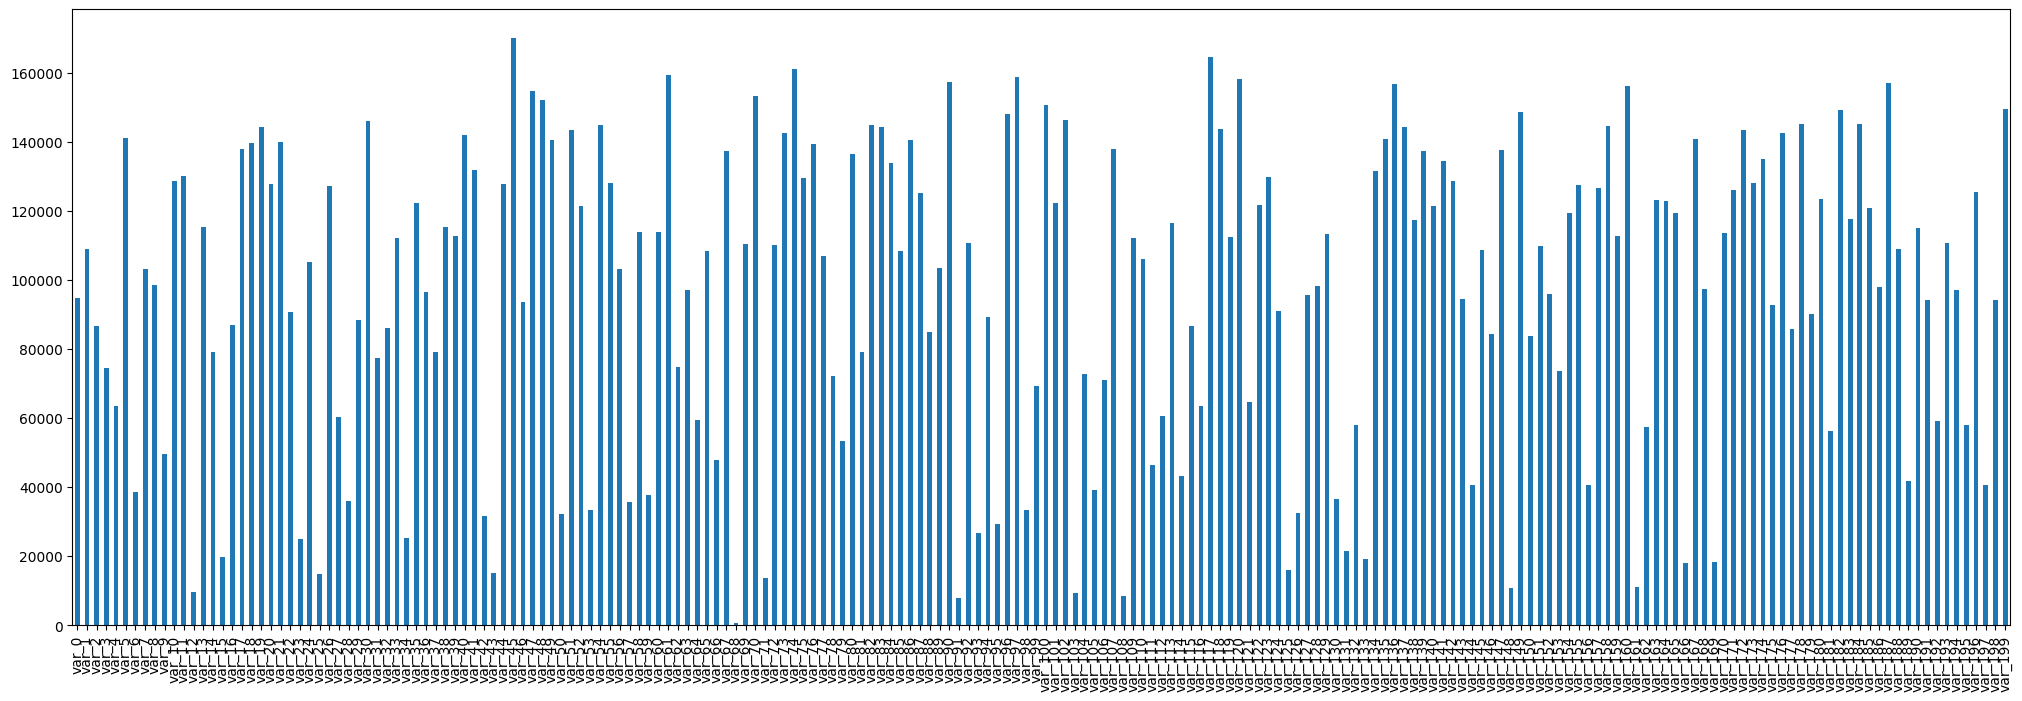

In [ ]:
plt.figure(figsize=(25,8))
train_df.drop(['ID_code', 'target'], axis=1).nunique().plot(kind='bar')

Most features have more than thousands of values for each variable except **var_68**.

In [ ]:
train_df['var_68'].nunique()

451

If you notice carefully, **var_68** has the least number of uniques! It has only **451 unique values**. This is a special feature, for sure!

#### EDA - Visualization : Distribution of Mean Values per Row/Customer

Lets **exclude** the **target** column and '**ID_code**' from our feature list:

In [ ]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]

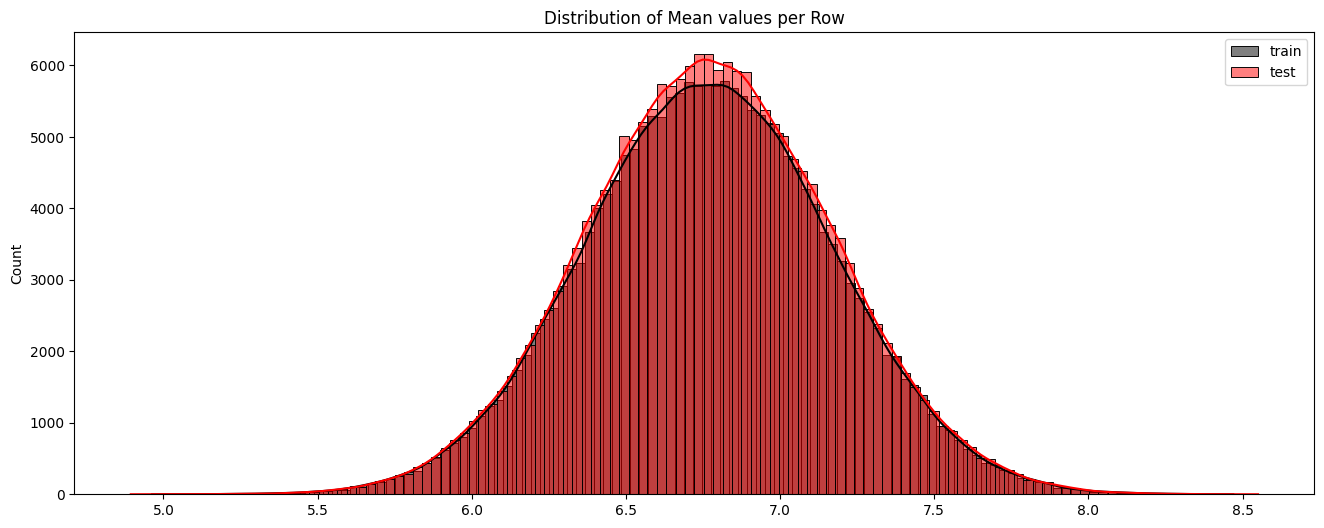

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of Mean values per Row")
sns.histplot(train_df[features].mean(axis=1),color="black", kde=True,bins=120, label='train')
sns.histplot(test_df[features].mean(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

The distribution looks more or less similar for both training and test data, as far as Mean for each row is concerned! For **test** dataset it is slightly **more** than the mean for **train** dataset. Both seem to have **normal distribution**.

#### EDA - Visualization : Distribution of Mean Values per Column/Feature

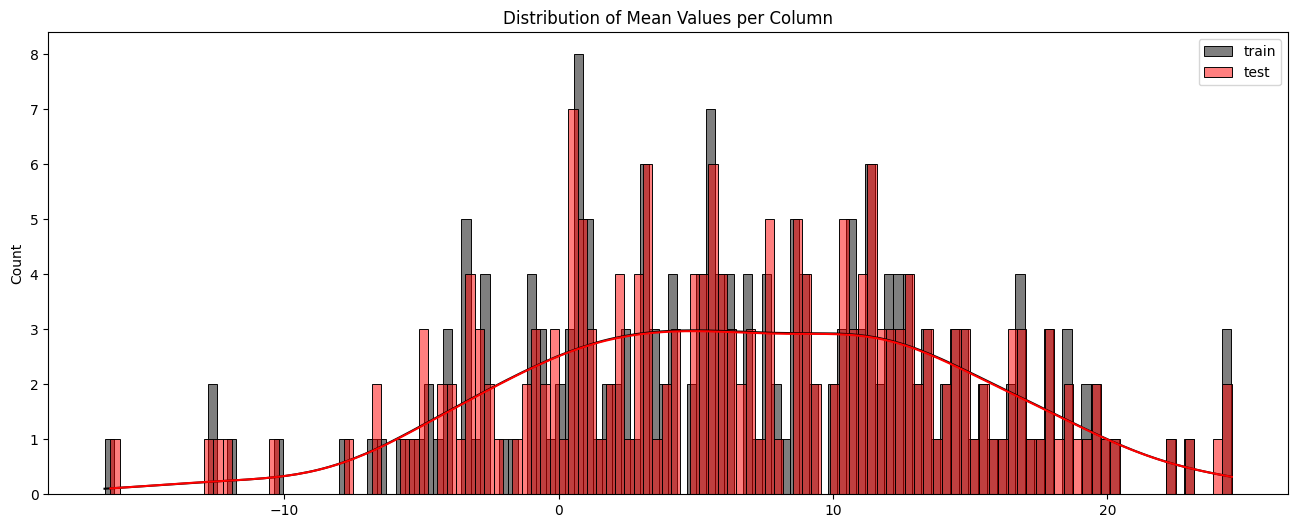

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of Mean Values per Column")
sns.histplot(train_df[features].mean(axis=0),color="black", kde=True,bins=120, label='train')
sns.histplot(test_df[features].mean(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

When we plotted Mean values for each feature then it shows fluctuations, it **doesn't seem to be normal** at all. But we can also notice that the columns have a **high range of means**.

#### EDA - Visualization : Distribution of Features

As we have 200 features in this dataset, so it will be cumbersome to plot the distribution for each one of them. Lets **visualize only 28** of them:

Distributions of first 28 columns


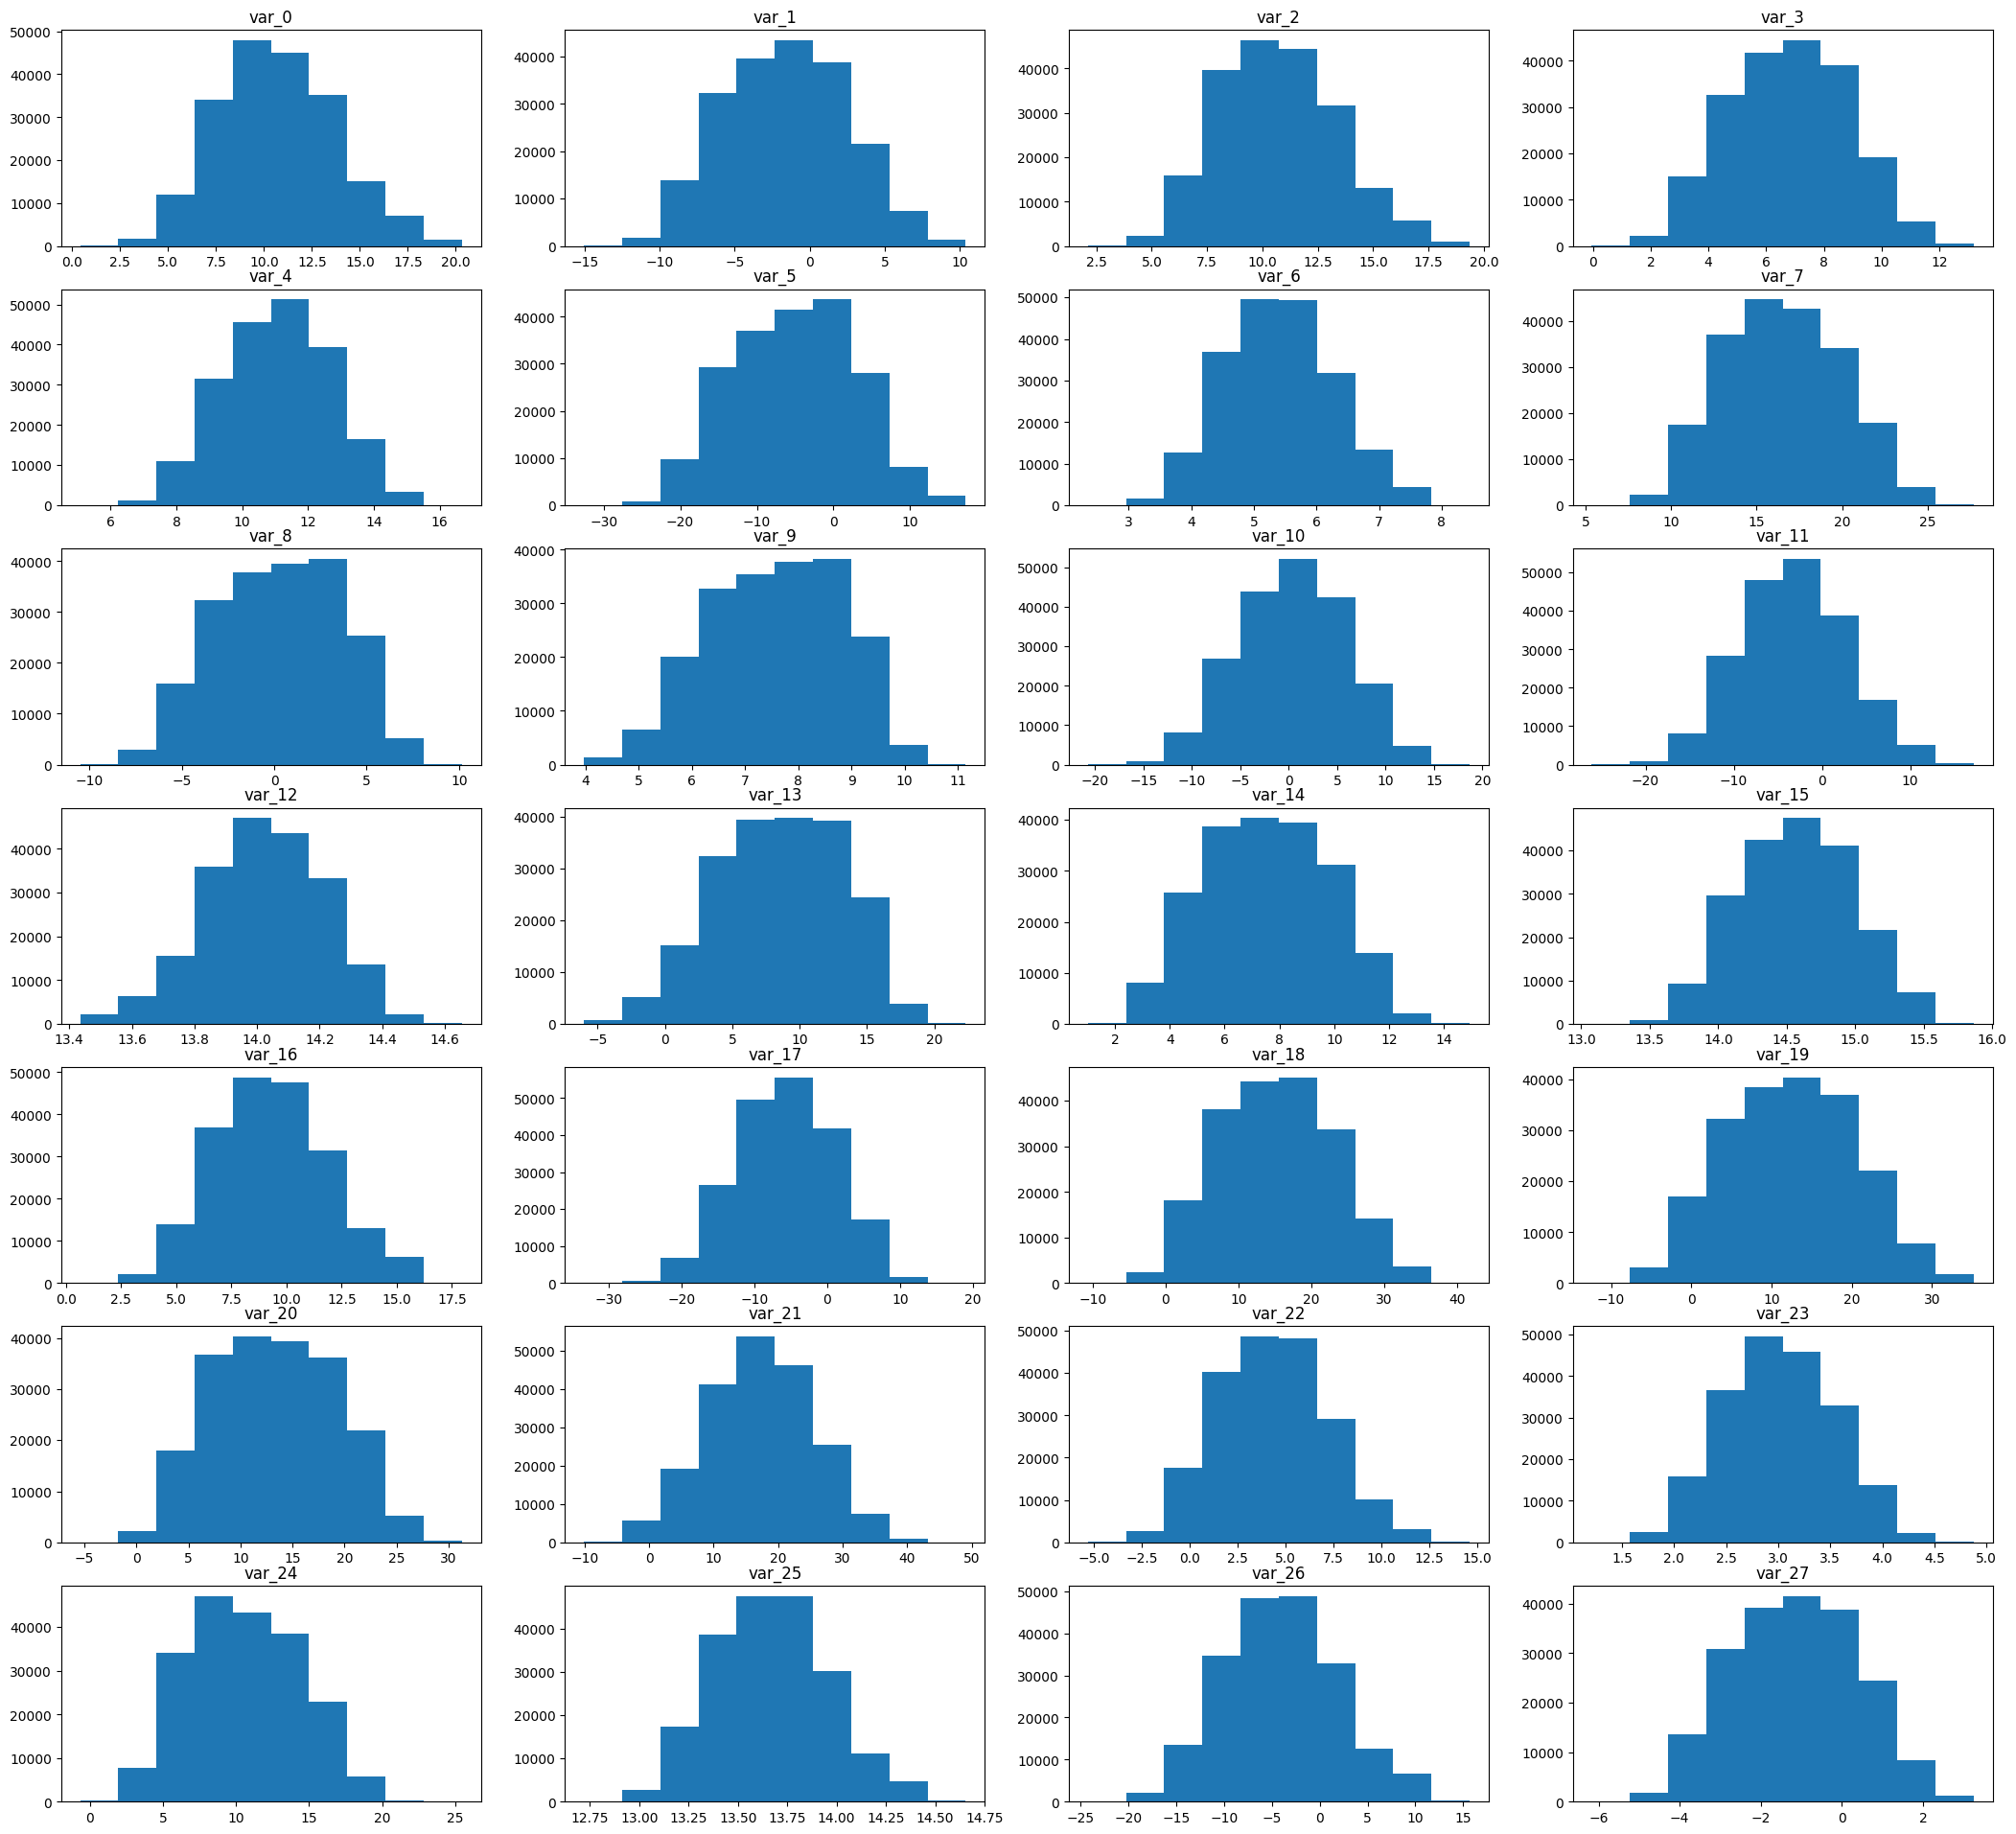

In [ ]:
print('Distributions of First 28 Columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train_df.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train_df[col])
    plt.title(col)

#### EDA - Visualization : `Distribution of var_68`


As we observed earlier that the feature '**var_68**' is a special feature in a way that it has minimum number of unique values so lets see how does its distribution looks like:

Text(0.5, 1.0, 'var_68')

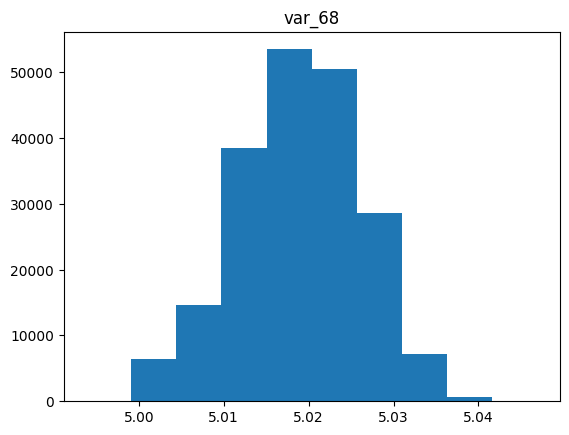

In [ ]:
plt.hist(train_df["var_68"])
plt.title("var_68")

This doesn't seem to have a wide range of values.

#### EDA - Visualization : Density Plots of Features

Lets choose two features (I chose **var_139** and **var_81**), to show the probability distribution/density plot of training as well as test data:

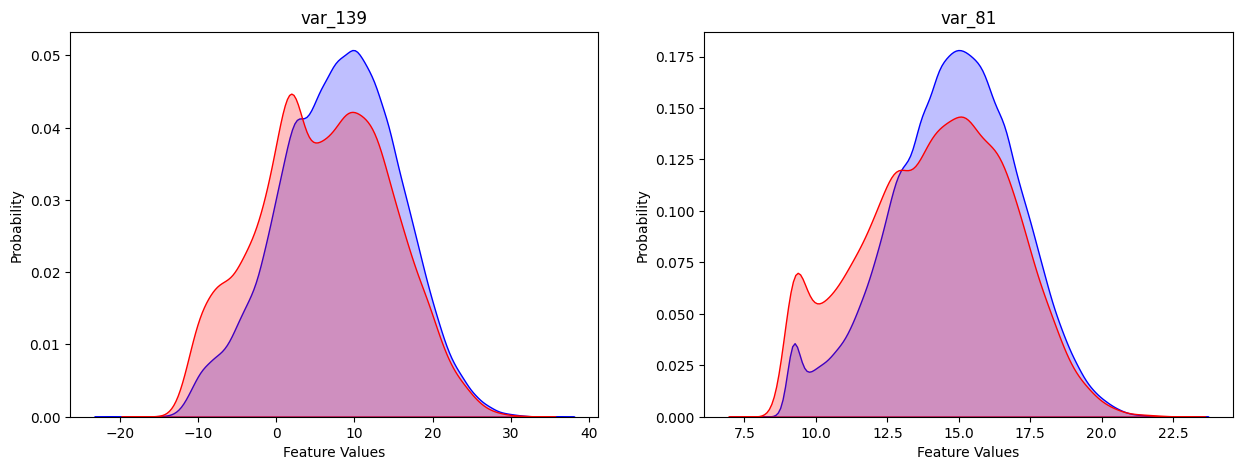

In [ ]:
feature_name = "var_139"
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(train_df[feature_name][train_df['target'] == 0], fill=True, color="b", label = 'target = 0')
sns.kdeplot(train_df[feature_name][train_df['target'] == 1], fill=True, color="r", label = 'target = 1')
plt.title(feature_name)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

feature_name = "var_81"
plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feature_name][train_df['target'] == 0], fill=True, color="b", label = 'target = 0')
sns.kdeplot(train_df[feature_name][train_df['target'] == 1], fill=True, color="r", label = 'target = 1')
plt.title(feature_name)
plt.xlabel('Feature Values')
plt.ylabel('Probability')
plt.show()

As you can see, there is a great motivation to calculate the PDF difference between target = 0 and target = 1 distributions. They are clearly different, so it would make sense to say that, if pdf(target = 1) - pdf(target = 0) > 0, then there is a high probability of the client making a transfer. Otherwise the customer won't make that transaction. Sounds convincing!!!

#### EDA - Visualization - Univariate Density Plots

Now we are going to plot univariate density plots, ofcourse not for all 200 features, so lets filter few of them.



In [ ]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(5,10,i)
        sns.kdeplot(df1[feature], color="b", legend=True, label=label1)
        sns.kdeplot(df2[feature], color="r", legend=True, label=label2)
        plt.xlabel(feature, fontsize=9)
        plt.legend(loc=8) # Legend will be placed in the lower center
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 640x480 with 0 Axes>

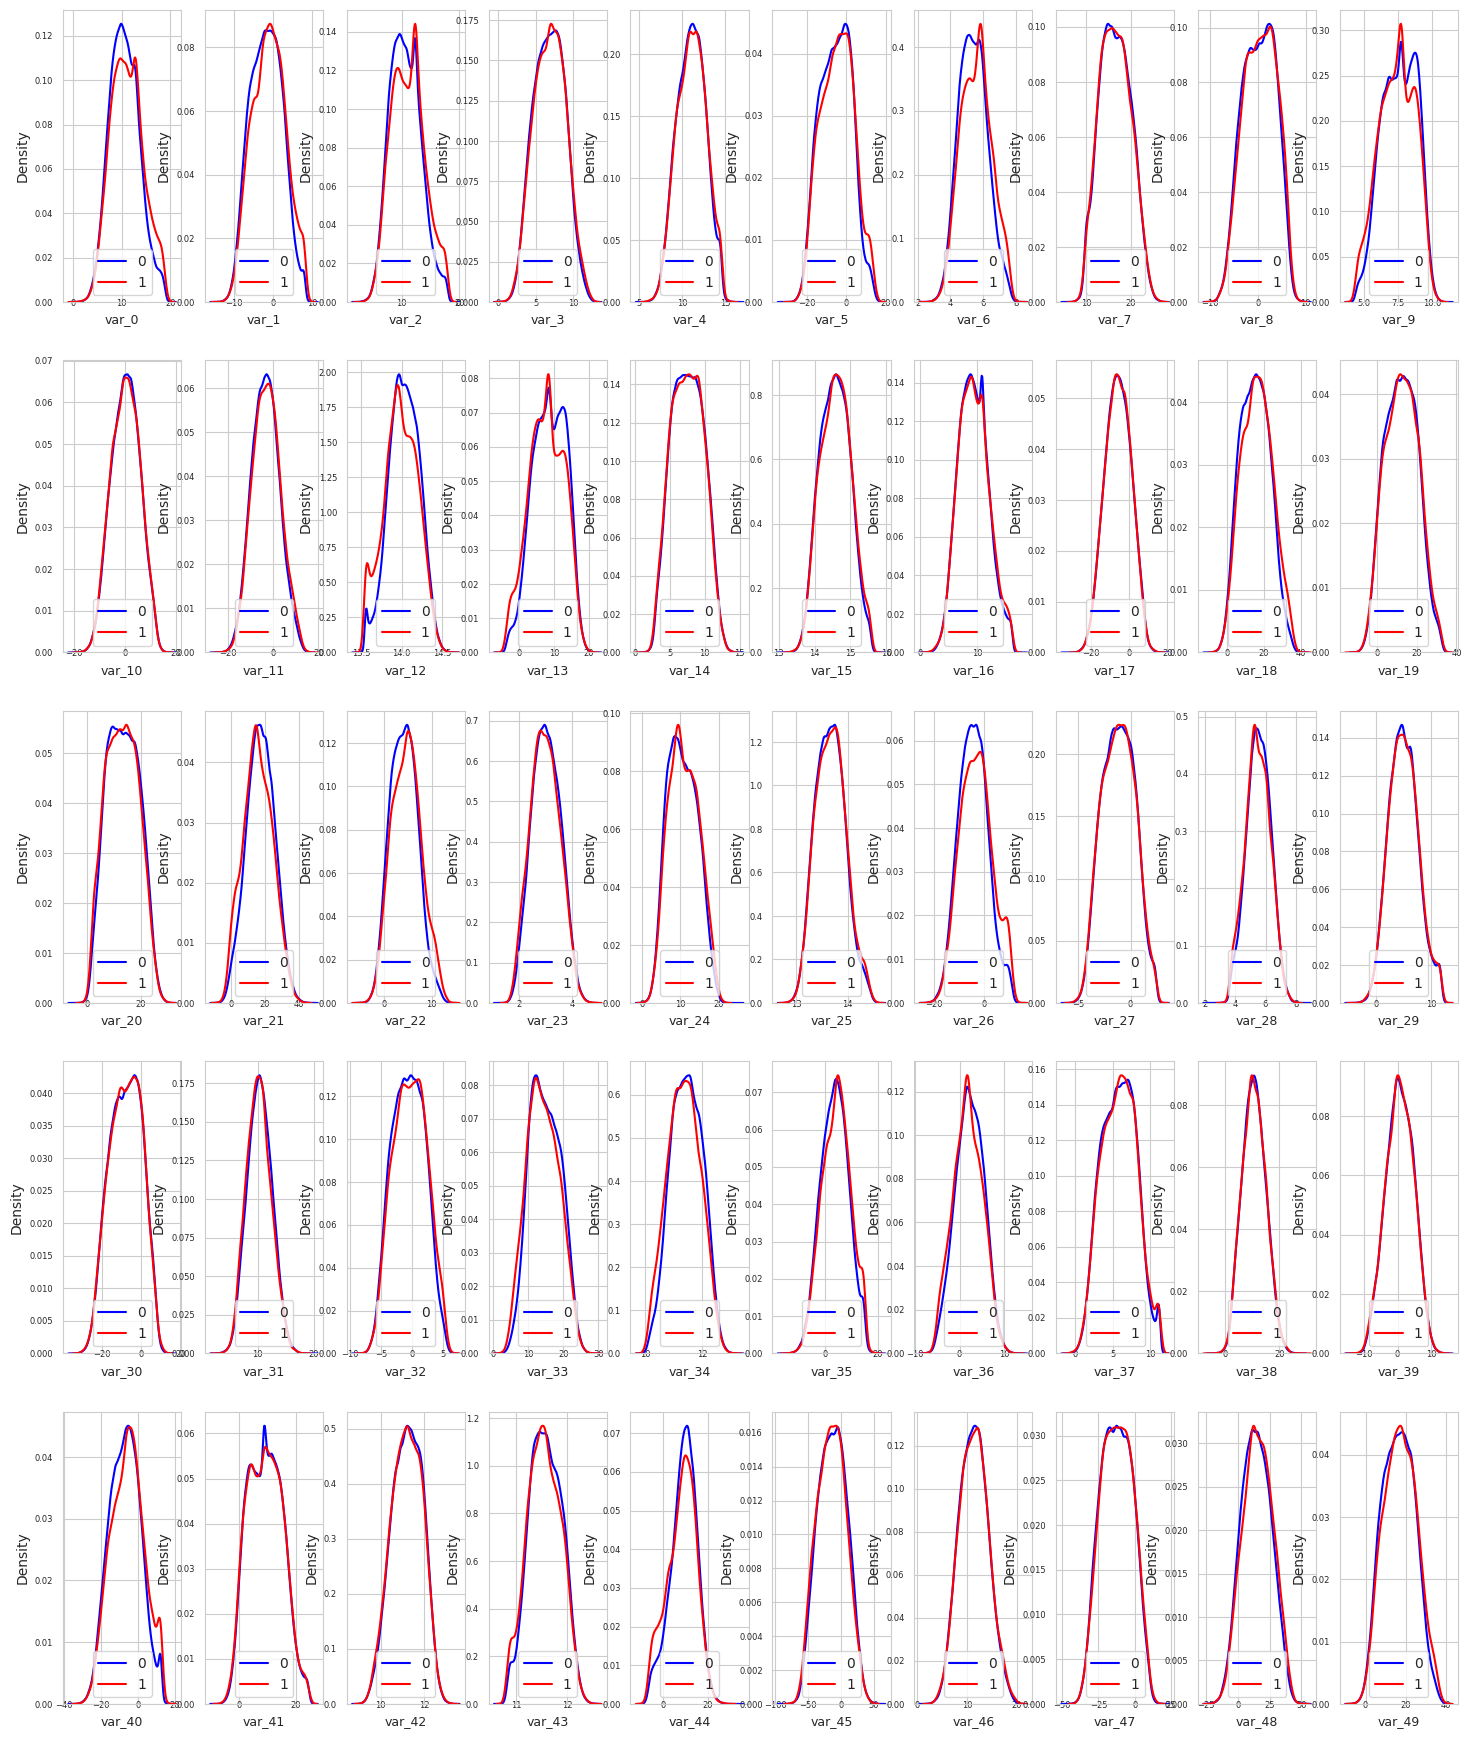

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:52]
plot_feature_distribution(t0, t1, '0', '1', features)

It is interesting to see that its **not** always **Normal** **distribution**, in some cases and classes we can observe almost **Bimodal** **distribution**. For example, features, like **var_2**, **var_9**, **var_13**, **var_16**, **var_41**, show bimodal distribution. So what is the implication? **Normality assumption is not met**, so we need to be careful in model choices etc if we were to use these predicators.

#### EDA - Visualization : Distribution of Train and Test data for Same Features

<Figure size 640x480 with 0 Axes>

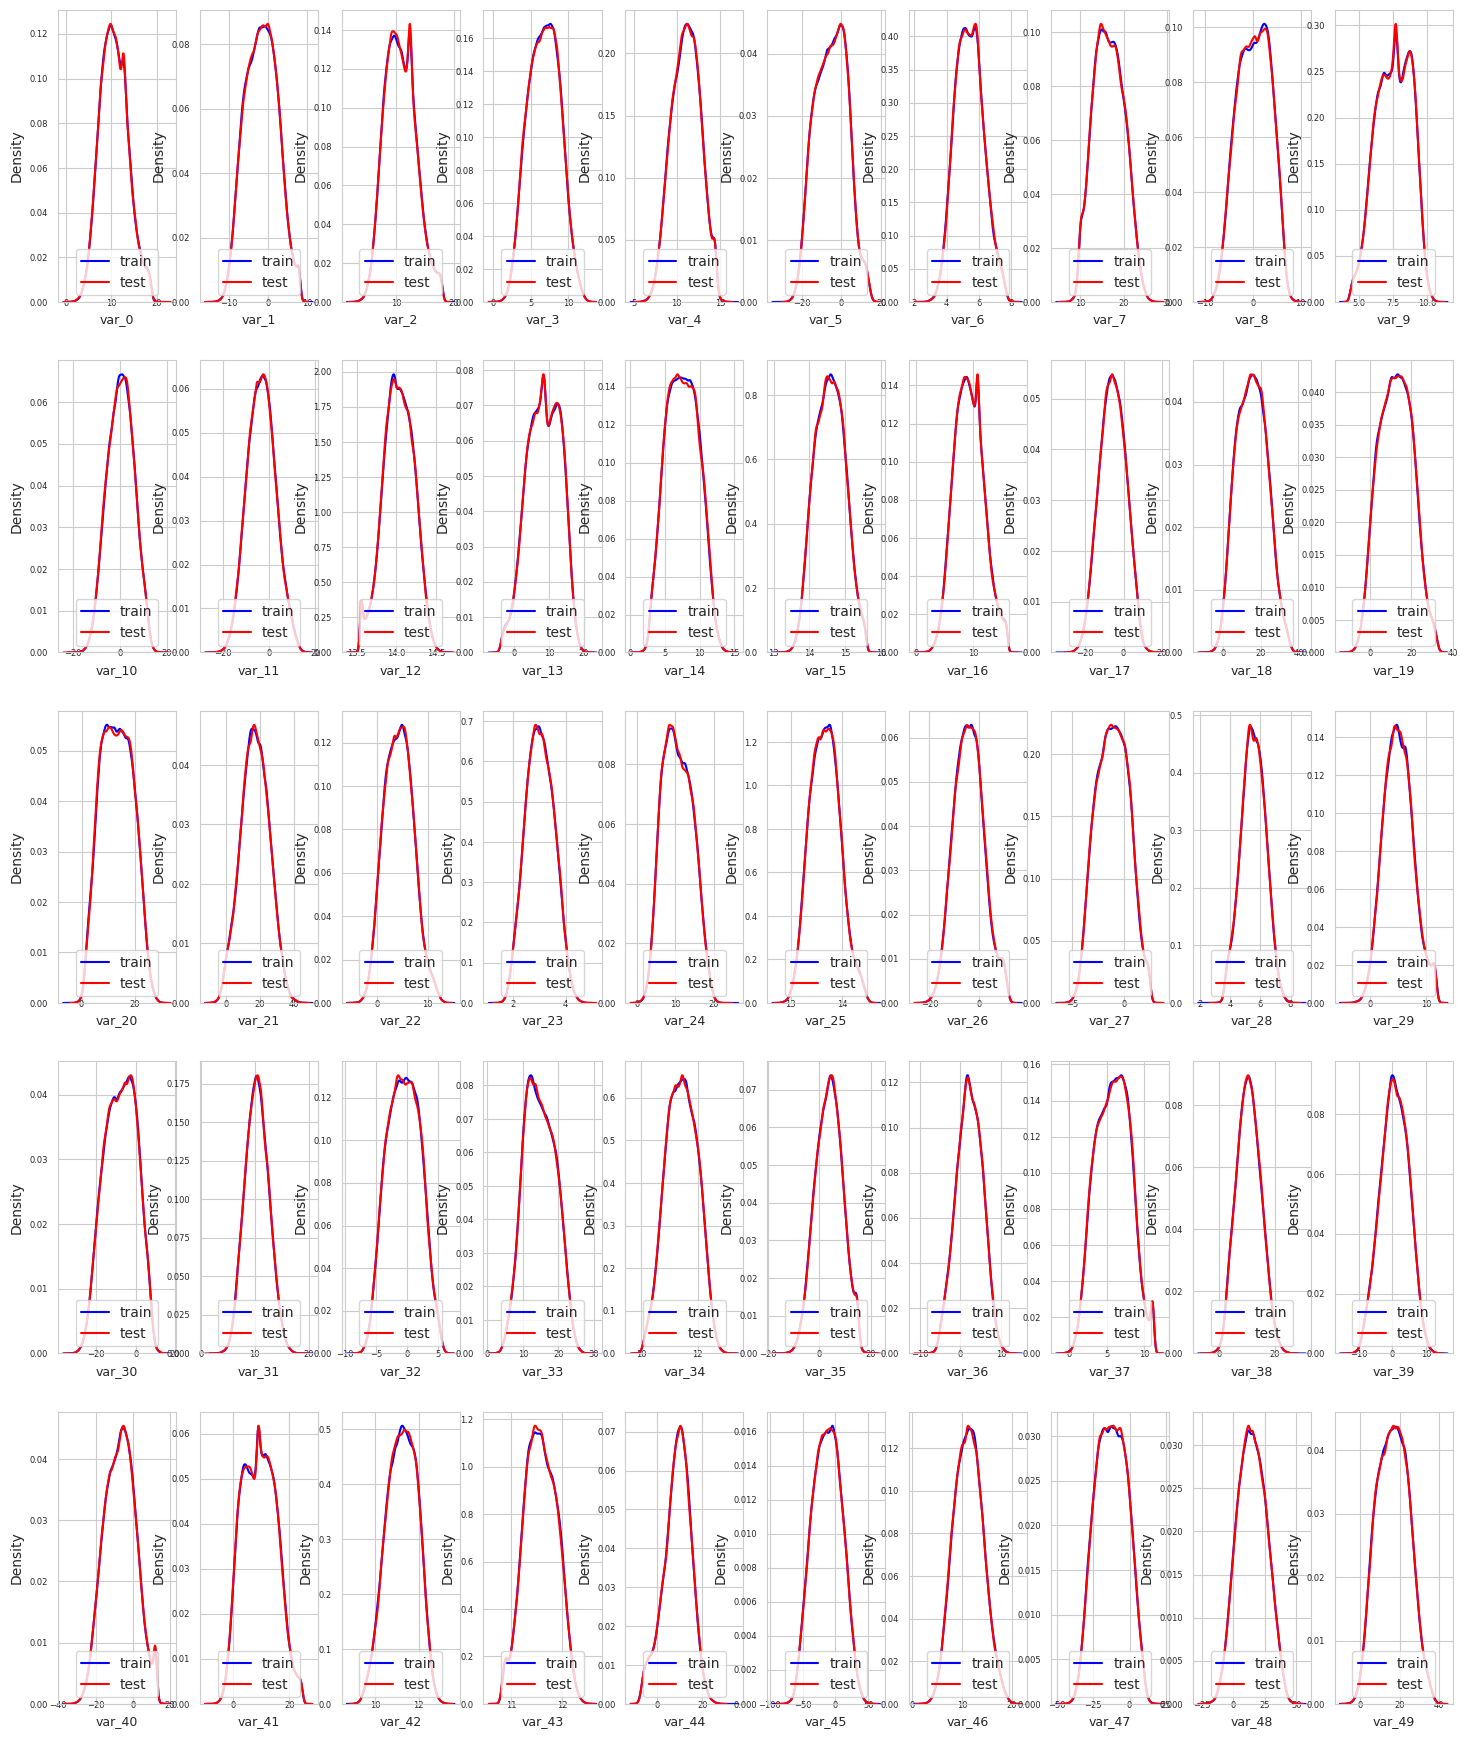

In [ ]:
features = train_df.columns.values[2:52]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

So we can see that **test and train sets are the same**, i.e. they come from the same sample and **they represent the whole population**.

#### EDA - Visualization : Features Correlation

200 potential predictors is a lot! So I wanted to see if I could reduce the size of the dataset by getting rid of highly correlated variables.

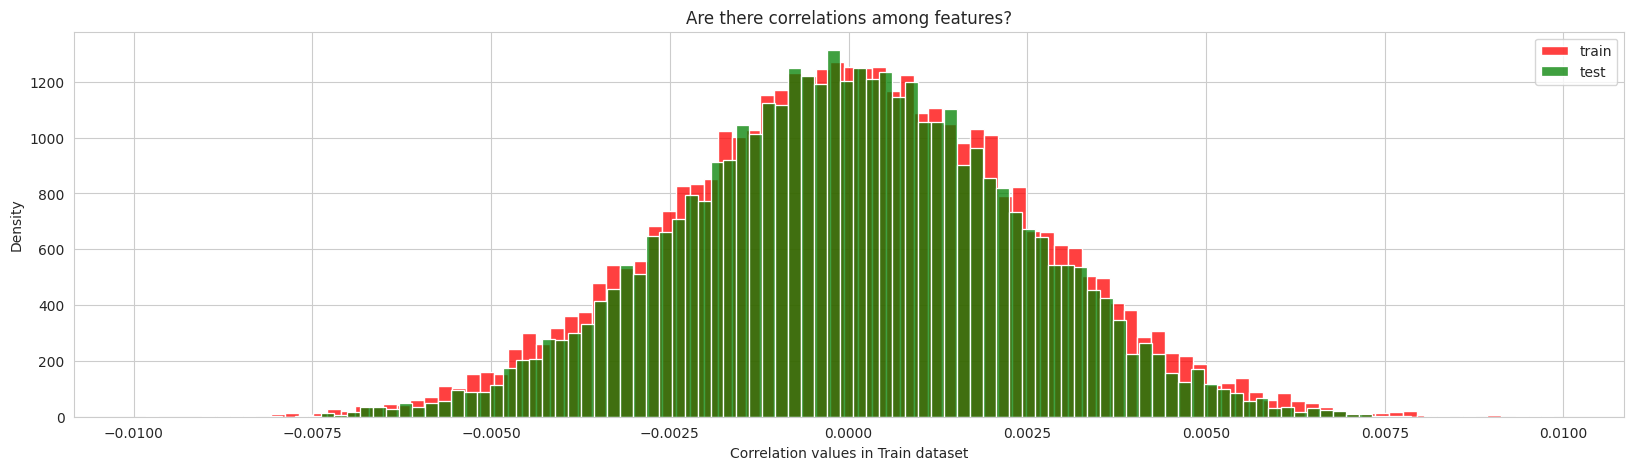

In [ ]:
train_correlations = train_df.drop(["ID_code","target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1] # As we don't want the diagonal elements with values 1

test_correlations = test_df.drop(["ID_code"], axis=1).corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1] # As we don't want the diagonal elements with values 1

plt.figure(figsize=(20,5))
sns.histplot(train_correlations, color="Red", label="train")
sns.histplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values in Train dataset")
plt.ylabel("Density")
plt.title("Are there correlations among features?");
plt.legend();

All features seem to have **no linear correlation**!!! **Neither in train nor in test**. Very strange! We know that they are anonymized and perhaps they are decorrelated by some transformation as well. Well, we can only speculate!

### Step 4 : Model Architecture 1

First we will consider a **simple architecture** for our **neural network** as our baseline model. So first we will see, how this baseline looks. Then later on, we will do some **hyperparameter tuning** or some **feature engineering** and more EDA to make some improvements.

In our first architecture we are taking all the inputs as the input dimension for first linear layer, because we don't know which feature is relevant and which is not. So for now all features are important. We also saw that all features are uncorrelated with each other, lets take that into account as well.

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(NN, self).__init__()
        self.bn = nn.BatchNorm1d(input_size) # Applies Batch Normalization over a 2D or 3D input
        self.fc1 = nn.Linear(1, hidden_dim) # First fully connected layer, considering every feature is uncorrelated with others
        self.fc2 = nn.Linear(input_size*hidden_dim, 1) # Second fully connected layer

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.bn(x)
        x = x.view(-1, 1)
        x = F.relu(self.fc1(x)).reshape(batch_size, -1)
        return torch.sigmoid(self.fc2(x)).view(-1) # Applies the element-wise function Sigmoid

In this model I am using **batch normalization** in the very beginning. We could also have scaled our inputs separately and skipped that step, but I tried that way.

According to the paper:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as **Internal Covariate Shift**, and address the problem by **normalizing layer inputs**.

#### Setting Hyperparameters

These are the hyperparameters which we can tune to see how our model performs and then come up with the best combination after training our model in many iterations:

In [ ]:
LEARNING_RATE = 2e-3
BATCH_SIZE = 1024
INPUT_SIZE = 200
WEIGHT_DECAY = 1e-4
HIDDEN_DIM = 16
NUM_EPOCHS = 5

#### Model Building

So for this baseline neural network we will be checking if CUDA is available and then moving our model to GPU will make the execution more fast!

As the class for our neural network takes **two arguments**, **input size** and **hidden dimension**. *Hidden dimension is the number of neurons in the hidden layer*. We only have two hidden layers in our network, very simple neural network to begin with!

Next we will choose our optimizer.`torch.optim` is a package implementing various **Optimization Algorithms**. To use `torch.optim` we have to construct an optimizer object that will hold the current state and will update the parameters based on the computed gradients.

To construct an **Optimizer** we have to give it an iterable containing the parameters to optimize. Then, we can specify optimizer-specific options such as the **learning rate**, **weight decay**, etc.

`nn.BCELoss()` creates a criterion that measures the **Binary Cross Entropy** between the target and the input probabilities.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = NN(input_size=INPUT_SIZE, hidden_dim=HIDDEN_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCELoss()

#### Data Loading through DataLoader

The **Dataset** retrieves our dataset's features and labels, one sample at a time. While training a model, we typically want to pass samples in "**minibatches**", reshuffle the data at every epoch to reduce model overfitting, and use Python's multiprocessing to speed up data retrieval.
**DataLoader** is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

x,y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([1024, 200]) torch.Size([1024])


Here **BATCH_SIZE** is a **hyperparameter** which suggests that during our model training, at each epoch the model is going to use only **1024** instances of our training data at a time, next epoch will pick another bunch of 1024 instances and so on.
As we can see that the torch size is 1024 by 200 because for every datapoint we have 200 features.

#### Function for Predictions

Now we will write a function which will get the predictions for a data loader.

Note that `torch.no_grad()` is kind of a **Context-Manager** that disables **gradient calculation**. This context manager is a local thread, it will not affect computation in other threads.

Disabling gradient calculation is useful for inference, when we are sure that we will not call `Tensor.backward()`. It will reduce memory consumption for computations that would otherwise have `requires_grad=True`.

In [ ]:
def get_predictions(loader, model, device):
    model.eval()
    saved_preds = []
    true_labels = []

    with torch.no_grad(): #BECAUSE WE DONT WANT UNNECESSARY COMPUTES
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            saved_preds += scores.tolist()
            true_labels += y.tolist()

    model.train()
    return saved_preds, true_labels

#### Model Training

This is where we are actually training our model.
Below, we have a function that performs one training epoch. It enumerates data from the **DataLoader**, and on each pass of the loop does the following:

*  Gets a **batch** of training data from the **DataLoader**

*  **Zeros the optimizer's gradients**

*  **Performs an inference** - that is, gets predictions from the model for an input batch

*  Calculates the **loss** for that set of predictions vs. the labels on the dataset

*  Calculates the **backward gradients** over the learning weights

*  Tells the optimizer to **perform one learning step** - that is, adjust the model's learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose (**Adam** here)

*  It **reports on the loss** for every N batches, wherein N=BATCH_SIZE.

*  Finally, it **reports the average per-batch loss** for the last N batches, for comparison with a validation run


`sklearn.metrics.roc_auc_score` computes **Area Under the Receiver Operating Characteristic Curve** (**ROC AUC**) from prediction scores.

In [ ]:
for epoch in range(NUM_EPOCHS):
  probabilities, true = get_predictions(val_loader, model, DEVICE)
  print(f"Epoch {epoch} : Validation ROC : {metrics.roc_auc_score(true, probabilities)}")
  #data, targets = next(iter(train_loader))
  for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
    data, targets = data.to(DEVICE), targets.to(DEVICE)

    outputs = model(data)
    loss = loss_fn(outputs, targets)
    #print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch 0 : Validation ROC : 0.4956192290382275


100%|██████████| 157/157 [00:06<00:00, 24.61it/s]


Epoch 1 : Validation ROC : 0.8839299706038936


100%|██████████| 157/157 [00:07<00:00, 21.80it/s]


Epoch 2 : Validation ROC : 0.8915477055633335


100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


Epoch 3 : Validation ROC : 0.8937767619721131


100%|██████████| 157/157 [00:06<00:00, 25.24it/s]


Epoch 4 : Validation ROC : 0.8956886993950389


100%|██████████| 157/157 [00:07<00:00, 21.56it/s]


#### Plotting Model Performance - AUC/ROC

One really strong way to evaluate the prediction power of a classifier is by plotting the **ROC** (**Receiver Operating Characteristic**) Curve.

This curve shows us the behavior of the classifier for every threshold by plotting two variables: the True Positive Rate (**TPR**) and the False Positive Rate (**FPR**).

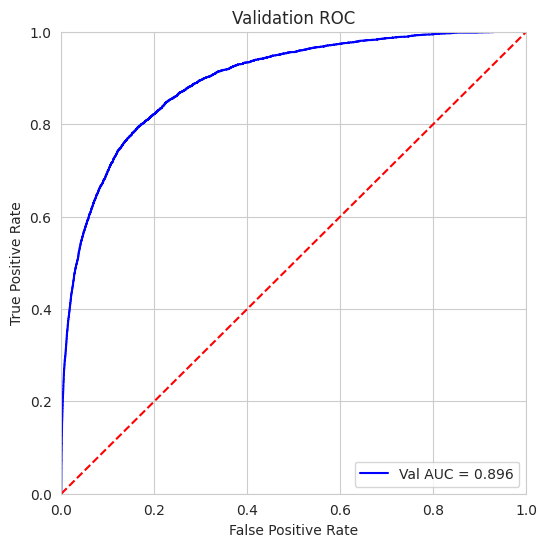

In [ ]:
probabilities, true = get_predictions(val_loader, model, DEVICE)
fpr, tpr, threshold = metrics.roc_curve(true, probabilities)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Model 1 : Results

I did several rounds of model training in the process of **hyperparameter tuning**, I have consolidated them all in an **Excel** file and the link has been shared in **GitHub** as well. This is the screenshot here:


:

<img src="https://github.com/GVworkds/Deep-Learning-Finals/blob/main/Model%20Architecture%201%20Results.png?raw=true">

So looks like, the **learning rate** "**2e-3**" and **number of epochs** **50** gave the best results. On kaggle I could get a score of **~0.897** which is good, **but not in the top 1%**. **So what could we do to improve the model performance?** Is there any architecture change we can do? But where to start?

How about we check few more things in our data and do some more **feature engineering** and based on those insights we could **change our deep learning model architecture** as well. So lets get started!

### Step 5 : Feature Engineering

We all know that **Feature Engineering** is a very experimental process. We could try to speculate what could be more useful for that network.

For example, we could use some insights from the EDA we have done so far. We saw that for a particular feature if we have some value for a particular customer and it is not unique. Some other customer could also have the very same value for that feature. So they are not unique. Maybe this is giving us some information. **What if the values that are unique are real samples and the duplicated ones are the fake ones or synthetic data**. If we could derive some information from this peice of information then our neural network could derive more information if we tell that a particular value of a feature is unique is unique in the dataset and other is not. Well, we could not say that for sure unless we give it a try and train a neural network on those features.

We don't need target information here, to know **whether a feature value is unique** in that column or not. So this is **Unsupervised** process. We could also use our test dataset for this.

Given a sample, we can go over its features and check if the feature value is unique. If at least one of the sample's features is unique, then the sample must be a real sample. It turns out that if a given sample has no unique values then it is a synthetic sample.

In [ ]:
train = pd.read_csv("/content/santander-customer-transaction-prediction/train.csv")
test = pd.read_csv("/content/santander-customer-transaction-prediction/test.csv")

In [ ]:
col_names = [f"var_{i}" for i in range(200)]
for col in tqdm(col_names):
    count = test[col].value_counts()
    uniques = count.index[count == 1]
    test[col + "_u"] = test[col].isin(uniques)

test["has_unique"] = test[[col + "_u" for col in col_names]].any(axis=1)

If for a particular customer we have even a single feature having an unique value then we set `has_unique` value as 1 otherwise it is 0.

In [ ]:
test["has_unique"].sum()

100000

So we have 100,000 unique entries out of 200,000. It is 50-50 in our test data!

In [ ]:
real_test = test.loc[test["has_unique"], ["ID_code"] + col_names]
fake_test = test.loc[~test["has_unique"], ["ID_code"] + col_names]
train_and_test = pd.concat([train, real_test], axis=0)

In [ ]:
for col in tqdm(col_names):
    count = train_and_test[col].value_counts().to_dict()
    train_and_test[col+"_unique"] = train_and_test[col].apply(
        lambda x: 1 if count[x] == 1 else 0).values
    fake_test[col+"_unique"] = 0

In [ ]:
real_test = train_and_test[train_and_test["ID_code"].str.contains("test")].copy()
real_test.drop(["target"], axis=1, inplace=True) # We are dropping the target as it got copied earlier
train = train_and_test[train_and_test["ID_code"].str.contains("train")].copy()

In [ ]:
test = pd.concat([real_test, fake_test], axis=0) # Now this is our final test, with both real and fake examples

In [ ]:
train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_1_unique,var_2_unique,var_3_unique,var_4_unique,var_5_unique,var_6_unique,var_7_unique,var_8_unique,var_9_unique,var_10_unique,var_11_unique,var_12_unique,var_13_unique,var_14_unique,var_15_unique,var_16_unique,var_17_unique,var_18_unique,var_19_unique,var_20_unique,var_21_unique,var_22_unique,var_23_unique,var_24_unique,var_25_unique,var_26_unique,var_27_unique,var_28_unique,var_29_unique,var_30_unique,var_31_unique,var_32_unique,var_33_unique,var_34_unique,var_35_unique,var_36_unique,var_37_unique,var_38_unique,var_39_unique,var_40_unique,var_41_unique,var_42_unique,var_43_unique,var_44_unique,var_45_unique,var_46_unique,var_47_unique,var_48_unique,var_49_unique,var_50_unique,var_51_unique,var_52_unique,var_53_unique,var_54_unique,var_55_unique,var_56_unique,var_57_unique,var_58_unique,var_59_unique,var_60_unique,var_61_unique,var_62_unique,var_63_unique,var_64_unique,var_65_unique,var_66_unique,var_67_unique,var_68_unique,var_69_unique,var_70_unique,var_71_unique,var_72_unique,var_73_unique,var_74_unique,var_75_unique,var_76_unique,var_77_unique,var_78_unique,var_79_unique,var_80_unique,var_81_unique,var_82_unique,var_83_unique,var_84_unique,var_85_unique,var_86_unique,var_87_unique,var_88_unique,var_89_unique,var_90_unique,var_91_unique,var_92_unique,var_93_unique,var_94_unique,var_95_unique,var_96_unique,var_97_unique,var_98_unique,var_99_unique,var_100_unique,var_101_unique,var_102_unique,var_103_unique,var_104_unique,var_105_unique,var_106_unique,var_107_unique,var_108_unique,var_109_unique,var_110_unique,var_111_unique,var_112_unique,var_113_unique,var_114_unique,var_115_unique,var_116_unique,var_117_unique,var_118_unique,var_119_unique,var_120_unique,var_121_unique,var_122_unique,var_123_unique,var_124_unique,var_125_unique,var_126_unique,var_127_unique,var_128_unique,var_129_unique,var_130_unique,var_131_unique,var_132_unique,var_133_unique,var_134_unique,var_135_unique,var_136_unique,var_137_unique,var_138_unique,var_139_unique,var_140_unique,var_141_unique,var_142_unique,var_143_unique,var_144_unique,var_145_unique,var_146_unique,var_147_unique,var_148_unique,var_149_unique,var_150_unique,var_151_unique,var_152_unique,var_153_unique,var_154_unique,var_155_unique,var_156_unique,var_157_unique,var_158_unique,var_159_unique,var_160_unique,var_161_unique,var_162_unique,var_163_unique,var_164_unique,var_165_unique,var_166_unique,var_167_unique,var_168_unique,var_169_unique,var_170_unique,var_171_unique,var_172_unique,var_173_u

So for every feature we have an extra column i.e. for **var_191** we have **var_191_unique** which has values as 0 and 1 and so on. So in total we have **400 features** now.

In [ ]:
test

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_1_unique,var_2_unique,var_3_unique,var_4_unique,var_5_unique,var_6_unique,var_7_unique,var_8_unique,var_9_unique,var_10_unique,var_11_unique,var_12_unique,var_13_unique,var_14_unique,var_15_unique,var_16_unique,var_17_unique,var_18_unique,var_19_unique,var_20_unique,var_21_unique,var_22_unique,var_23_unique,var_24_unique,var_25_unique,var_26_unique,var_27_unique,var_28_unique,var_29_unique,var_30_unique,var_31_unique,var_32_unique,var_33_unique,var_34_unique,var_35_unique,var_36_unique,var_37_unique,var_38_unique,var_39_unique,var_40_unique,var_41_unique,var_42_unique,var_43_unique,var_44_unique,var_45_unique,var_46_unique,var_47_unique,var_48_unique,var_49_unique,var_50_unique,var_51_unique,var_52_unique,var_53_unique,var_54_unique,var_55_unique,var_56_unique,var_57_unique,var_58_unique,var_59_unique,var_60_unique,var_61_unique,var_62_unique,var_63_unique,var_64_unique,var_65_unique,var_66_unique,var_67_unique,var_68_unique,var_69_unique,var_70_unique,var_71_unique,var_72_unique,var_73_unique,var_74_unique,var_75_unique,var_76_unique,var_77_unique,var_78_unique,var_79_unique,var_80_unique,var_81_unique,var_82_unique,var_83_unique,var_84_unique,var_85_unique,var_86_unique,var_87_unique,var_88_unique,var_89_unique,var_90_unique,var_91_unique,var_92_unique,var_93_unique,var_94_unique,var_95_unique,var_96_unique,var_97_unique,var_98_unique,var_99_unique,var_100_unique,var_101_unique,var_102_unique,var_103_unique,var_104_unique,var_105_unique,var_106_unique,var_107_unique,var_108_unique,var_109_unique,var_110_unique,var_111_unique,var_112_unique,var_113_unique,var_114_unique,var_115_unique,var_116_unique,var_117_unique,var_118_unique,var_119_unique,var_120_unique,var_121_unique,var_122_unique,var_123_unique,var_124_unique,var_125_unique,var_126_unique,var_127_unique,var_128_unique,var_129_unique,var_130_unique,var_131_unique,var_132_unique,var_133_unique,var_134_unique,var_135_unique,var_136_unique,var_137_unique,var_138_unique,var_139_unique,var_140_unique,var_141_unique,var_142_unique,var_143_unique,var_144_unique,var_145_unique,var_146_unique,var_147_unique,var_148_unique,var_149_unique,var_150_unique,var_151_unique,var_152_unique,var_153_unique,var_154_unique,var_155_unique,var_156_unique,var_157_unique,var_158_unique,var_159_unique,var_160_unique,var_161_unique,var_162_unique,var_163_unique,var_164_unique,var_165_unique,var_166_unique,var_167_unique,var_168_unique,var_169_unique,var_170_unique,var_171_unique,var_172_unique,var_173_unique,v

As you can see above, we have almost **doubled our columns in both train and test** data. The new columns we have added is **binary column**, having values either 0 or 1. So if it is 1 that means the corresponding value for that feature is unique i.e. its not repeated anywhere in entire dataset. And if it is 0 then that means the corresponding value for that feature is not unique i.e. it is present elsewhere for some other customer in the dataset. Hopefully these columns will be very useful in determining the target value. Model has some extra bits of information now.

Now we will save these files to be used later on by our second model.

In [ ]:
train.to_csv("new_shiny_train.csv", index=False)
test.to_csv("new_shiny_test.csv", index=False)

### Step 6 : Model Architecture 2

Now we can modify our model architecture to accomodate the newly engineered features in our training and test data. The columns to indicate whether a particular feature value is unique or not.

#### Setting Hyperparameters

These are the hyperparameters which we can tune to see how our model performs and then come up with the best combination after training our model in many iterations, you can notice that the input size is 400 now, earlier it was only 200:

In [ ]:
LEARNING_RATE = 5e-4
BATCH_SIZE = 1024
INPUT_SIZE = 400
WEIGHT_DECAY = 1e-4
HIDDEN_DIM = 100
NUM_EPOCHS = 75

#### Topology of Neural Network

In this architecture, we have added columns after feature engineering i.e. now we have double features and for each of them we either pick them if they are unique/real or reject them if they are non-unique/fake. Earlier we had 200 features and there was no correlation among the features but now we have 400 features and obviously we have correlations among the features. **That is the reason the first fully connected layer in this neural network has only 2 inputs**, unique or non-unique. Maybe that will give our model some additional information.

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(NN, self).__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(2, hidden_dim) # Here we have 2 as first argument, in first model it was 1
        self.fc2 = nn.Linear(input_size//2*hidden_dim, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.bn(x)

        #First 200 features are the original features
        orig_features = x[:, :200].unsqueeze(2) # (batch_size, 200, 1)

        #Last 200 features are the new features added in feature engineering
        new_features = x[:, 200:].unsqueeze(2) # (batch_size, 200, 1)

        #Now we are concatenating both of them
        x = torch.cat([orig_features, new_features], dim=2) # (batch_size, 200, 2)
        x = F.relu(self.fc1(x)).reshape(batch_size, -1)  # (batch_size, 200*hidden_dim)
        x = self.fc2(x)
        return torch.sigmoid(x).view(-1)


Now the training and test files have been updated and the path should be updated as well, otherwise it would pick the original files:

In [ ]:
train_file_path = "/content/drive/MyDrive/Deep Learning/Final Project/Data/new_shiny_train.csv"
test_file_path = "/content/drive/MyDrive/Deep Learning/Final Project/Data/new_shiny_test.csv"

#### Loading Data into PyTorch Dataset

In the method `get_data()` I am using `TensorDataset`.
In practice, loading our data into a **PyTorch** dataset will be one of the first steps we take in order to create and train a **neural network** with PyTorch.

The **TensorDataset** class is very helpful when our dataset can be loaded directly as a `NumPy` array. Recall that `TensorDataset()` can take one or more NumPy arrays as input.

We will start with the **given input files** for train and test datasets.

In [ ]:
train_ds, val_ds, test_ds, test_ids, train_df, test_df = get_data()

#### Model Building

So for this neural network we will be checking if **CUDA** is available and then moving our model to GPU will make the execution more fast! Otherwise it will use CPU by default.

As the class for our neural network takes two arguments, input size and hidden dimension. Hidden dimension is the number of neurons in the hidden layer. We only have two hidden layers in our network, very simple neural network to begin with!

Next we will choose our `optimizer.torch.optim` is a package implementing various **Optimization** Algorithms. To use `torch.optim` we have to construct an optimizer object that will hold the current state and will update the parameters based on the computed gradients.

To construct an **Optimizer** we have to give it an iterable containing the parameters to optimize. Then, we can specify optimizer-specific options such as the learning rate, weight decay, etc.

`nn.BCELoss()` creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = NN(input_size=INPUT_SIZE, hidden_dim=HIDDEN_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCELoss()

#### Data Loading through DataLoader

The **Dataset** retrieves our dataset's features and labels, one sample at a time. While training a model, we typically want to pass samples in "**minibatches**", reshuffle the data at every epoch to reduce model overfitting, and use Python's multiprocessing to speed up data retrieval.
**DataLoader** is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

x,y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([1024, 400]) torch.Size([1024])


#### Model Training

This is where we are actually training our model.
Below, we have a function that performs one training epoch. It enumerates data from the **DataLoader**, and on each pass of the loop does the following:

*  Gets a **batch** of training data from the **DataLoader**

*  **Zeros the optimizer's gradients**

*  **Performs an inference** - that is, gets predictions from the model for an input batch

*  Calculates the **loss** for that set of predictions vs. the labels on the dataset

*  Calculates the **backward gradients** over the learning weights

*  Tells the optimizer to **perform one learning step** - that is, adjust the model's learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose (**Adam** here)

*  It **reports on the loss** for every N batches, wherein N=BATCH_SIZE.

*  Finally, it **reports the average per-batch loss** for the last N batches, for comparison with a validation run


In [ ]:
all_preds = []
all_rocs = []
for epoch in range(NUM_EPOCHS):
  probabilities, true = get_predictions(val_loader, model, DEVICE)
  roc = metrics.roc_auc_score(true, probabilities)
  all_preds.append(probabilities)
  all_rocs.append(roc)
  print(f"Epoch {epoch} : Validation ROC : {roc}")
  #data, targets = next(iter(train_loader))
  for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
    data, targets = data.to(DEVICE), targets.to(DEVICE)

    outputs = model(data)
    loss = loss_fn(outputs, targets)
    #print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 : Validation ROC : 0.5023118339432747


100%|██████████| 157/157 [00:03<00:00, 42.79it/s]


Epoch 1 : Validation ROC : 0.8866590739923694


100%|██████████| 157/157 [00:03<00:00, 47.34it/s]


Epoch 2 : Validation ROC : 0.8997470628149767


100%|██████████| 157/157 [00:05<00:00, 30.61it/s]


Epoch 3 : Validation ROC : 0.9053403961518116


100%|██████████| 157/157 [00:04<00:00, 38.38it/s]


Epoch 4 : Validation ROC : 0.9071724525339108


100%|██████████| 157/157 [00:05<00:00, 28.64it/s]


Epoch 5 : Validation ROC : 0.9092831890829798


100%|██████████| 157/157 [00:03<00:00, 39.35it/s]


Epoch 6 : Validation ROC : 0.9109631828158203


100%|██████████| 157/157 [00:04<00:00, 35.33it/s]


Epoch 7 : Validation ROC : 0.9116765310664602


100%|██████████| 157/157 [00:05<00:00, 29.84it/s]


Epoch 8 : Validation ROC : 0.9129122543228321


100%|██████████| 157/157 [00:04<00:00, 34.41it/s]


Epoch 9 : Validation ROC : 0.9137218372772643


100%|██████████| 157/157 [00:05<00:00, 26.85it/s]


Epoch 10 : Validation ROC : 0.914065291267698


100%|██████████| 157/157 [00:04<00:00, 33.49it/s]


Epoch 11 : Validation ROC : 0.9147992990025204


100%|██████████| 157/157 [00:05<00:00, 31.01it/s]


Epoch 12 : Validation ROC : 0.9152709565122108


100%|██████████| 157/157 [00:03<00:00, 41.49it/s]


Epoch 13 : Validation ROC : 0.915734182989721


100%|██████████| 157/157 [00:04<00:00, 32.17it/s]


Epoch 14 : Validation ROC : 0.916253593312826


100%|██████████| 157/157 [00:03<00:00, 42.83it/s]


Epoch 15 : Validation ROC : 0.9167963099113638


100%|██████████| 157/157 [00:04<00:00, 36.08it/s]


Epoch 16 : Validation ROC : 0.9169499585621679


100%|██████████| 157/157 [00:05<00:00, 30.48it/s]


Epoch 17 : Validation ROC : 0.9173563204918945


100%|██████████| 157/157 [00:04<00:00, 39.19it/s]


Epoch 18 : Validation ROC : 0.9175778251303859


100%|██████████| 157/157 [00:03<00:00, 43.25it/s]


Epoch 19 : Validation ROC : 0.9181926719734993


100%|██████████| 157/157 [00:04<00:00, 33.44it/s]


Epoch 20 : Validation ROC : 0.9183127450752475


100%|██████████| 157/157 [00:03<00:00, 39.65it/s]


Epoch 21 : Validation ROC : 0.91854712776986


100%|██████████| 157/157 [00:04<00:00, 33.49it/s]


Epoch 22 : Validation ROC : 0.9188715601077723


100%|██████████| 157/157 [00:03<00:00, 40.75it/s]


Epoch 23 : Validation ROC : 0.9187773640552038


100%|██████████| 157/157 [00:03<00:00, 43.43it/s]


Epoch 24 : Validation ROC : 0.9192434584657915


100%|██████████| 157/157 [00:04<00:00, 37.33it/s]


Epoch 25 : Validation ROC : 0.9196020503053981


100%|██████████| 157/157 [00:03<00:00, 46.90it/s]


Epoch 26 : Validation ROC : 0.9196797678364635


100%|██████████| 157/157 [00:03<00:00, 46.73it/s]


Epoch 27 : Validation ROC : 0.9198971122443217


100%|██████████| 157/157 [00:04<00:00, 37.14it/s]


Epoch 28 : Validation ROC : 0.9200962228174194


100%|██████████| 157/157 [00:03<00:00, 47.13it/s]


Epoch 29 : Validation ROC : 0.9202531402208636


100%|██████████| 157/157 [00:03<00:00, 46.52it/s]


Epoch 30 : Validation ROC : 0.9205137385880796


100%|██████████| 157/157 [00:03<00:00, 40.97it/s]


Epoch 31 : Validation ROC : 0.9204737568367032


100%|██████████| 157/157 [00:03<00:00, 45.77it/s]


Epoch 32 : Validation ROC : 0.920647584679283


100%|██████████| 157/157 [00:04<00:00, 35.87it/s]


Epoch 33 : Validation ROC : 0.9210341060406576


100%|██████████| 157/157 [00:03<00:00, 44.31it/s]


Epoch 34 : Validation ROC : 0.9207909018603253


100%|██████████| 157/157 [00:03<00:00, 46.62it/s]


Epoch 35 : Validation ROC : 0.9210309167608616


100%|██████████| 157/157 [00:04<00:00, 39.18it/s]


Epoch 36 : Validation ROC : 0.9207472194386764


100%|██████████| 157/157 [00:03<00:00, 46.78it/s]


Epoch 37 : Validation ROC : 0.9211739920680295


100%|██████████| 157/157 [00:03<00:00, 46.87it/s]


Epoch 38 : Validation ROC : 0.9213498274637639


100%|██████████| 157/157 [00:03<00:00, 40.09it/s]


Epoch 39 : Validation ROC : 0.921337522994258


100%|██████████| 157/157 [00:03<00:00, 46.97it/s]


Epoch 40 : Validation ROC : 0.9214234227729478


100%|██████████| 157/157 [00:03<00:00, 43.26it/s]


Epoch 41 : Validation ROC : 0.921397791052983


100%|██████████| 157/157 [00:04<00:00, 38.41it/s]


Epoch 42 : Validation ROC : 0.921490435657417


100%|██████████| 157/157 [00:03<00:00, 46.79it/s]


Epoch 43 : Validation ROC : 0.9216558912086142


100%|██████████| 157/157 [00:03<00:00, 44.80it/s]


Epoch 44 : Validation ROC : 0.9218722508442712


100%|██████████| 157/157 [00:04<00:00, 38.69it/s]


Epoch 45 : Validation ROC : 0.9217711406542465


100%|██████████| 157/157 [00:03<00:00, 47.21it/s]


Epoch 46 : Validation ROC : 0.9216119461810451


100%|██████████| 157/157 [00:03<00:00, 44.30it/s]


Epoch 47 : Validation ROC : 0.9218190904221013


100%|██████████| 157/157 [00:04<00:00, 38.96it/s]


Epoch 48 : Validation ROC : 0.9220273576490015


100%|██████████| 157/157 [00:03<00:00, 46.74it/s]


Epoch 49 : Validation ROC : 0.9221102754683584


100%|██████████| 157/157 [00:03<00:00, 44.01it/s]


Epoch 50 : Validation ROC : 0.9218728002434993


100%|██████████| 157/157 [00:03<00:00, 39.90it/s]


Epoch 51 : Validation ROC : 0.9220062800685507


100%|██████████| 157/157 [00:03<00:00, 46.77it/s]


Epoch 52 : Validation ROC : 0.922066206048511


100%|██████████| 157/157 [00:03<00:00, 42.81it/s]


Epoch 53 : Validation ROC : 0.9222466232264874


100%|██████████| 157/157 [00:03<00:00, 41.03it/s]


Epoch 54 : Validation ROC : 0.9221648594910437


100%|██████████| 157/157 [00:03<00:00, 44.51it/s]


Epoch 55 : Validation ROC : 0.9222285379713925


100%|██████████| 157/157 [00:04<00:00, 38.39it/s]


Epoch 56 : Validation ROC : 0.9222305973546627


100%|██████████| 157/157 [00:03<00:00, 45.84it/s]


Epoch 57 : Validation ROC : 0.9220878952243289


100%|██████████| 157/157 [00:03<00:00, 43.62it/s]


Epoch 58 : Validation ROC : 0.9221843268825616


100%|██████████| 157/157 [00:03<00:00, 40.25it/s]


Epoch 59 : Validation ROC : 0.9223376230885777


100%|██████████| 157/157 [00:03<00:00, 46.21it/s]


Epoch 60 : Validation ROC : 0.9222929628054096


100%|██████████| 157/157 [00:03<00:00, 43.73it/s]


Epoch 61 : Validation ROC : 0.9223233698067156


100%|██████████| 157/157 [00:04<00:00, 38.57it/s]


Epoch 62 : Validation ROC : 0.9222954160975605


100%|██████████| 157/157 [00:03<00:00, 46.24it/s]


Epoch 63 : Validation ROC : 0.922269369736669


100%|██████████| 157/157 [00:03<00:00, 46.47it/s]


Epoch 64 : Validation ROC : 0.9222318309114202


100%|██████████| 157/157 [00:04<00:00, 38.43it/s]


Epoch 65 : Validation ROC : 0.9223181073222851


100%|██████████| 157/157 [00:03<00:00, 43.88it/s]


Epoch 66 : Validation ROC : 0.9222141326545238


100%|██████████| 157/157 [00:03<00:00, 46.69it/s]


Epoch 67 : Validation ROC : 0.9222253694236429


100%|██████████| 157/157 [00:04<00:00, 38.15it/s]


Epoch 68 : Validation ROC : 0.9223360128996452


100%|██████████| 157/157 [00:03<00:00, 44.02it/s]


Epoch 69 : Validation ROC : 0.9223699719915583


100%|██████████| 157/157 [00:03<00:00, 46.48it/s]


Epoch 70 : Validation ROC : 0.9224941120297312


100%|██████████| 157/157 [00:03<00:00, 41.46it/s]


Epoch 71 : Validation ROC : 0.9224391997496453


100%|██████████| 157/157 [00:03<00:00, 43.57it/s]


Epoch 72 : Validation ROC : 0.9224955840050216


100%|██████████| 157/157 [00:03<00:00, 43.96it/s]


Epoch 73 : Validation ROC : 0.9225338242645051


100%|██████████| 157/157 [00:03<00:00, 40.48it/s]


Epoch 74 : Validation ROC : 0.9226476259222339


100%|██████████| 157/157 [00:03<00:00, 46.54it/s]


We can see above that the **Validation ROC** suddenly **jumps** from **~0.502** to **~0.887** in just **one epoch**! So this model **architecture** is definitely **better** that the earlier one. As we added some valuable features in our model!!!

So we got a final **Validation ROC** of **~0.923** which is simply amazing! The winners on kaggle got **~0.925**. We did not use any Ensemble and I did not add any more features.

#### Plotting Model Performance - AUC/ROC

One really strong way to evaluate the prediction power of a classifier is by plotting the **ROC** (**Receiver Operating Characteristic**) Curve.

This curve shows us the behavior of the classifier for every threshold by plotting two variables: the True Positive Rate (**TPR**) and the False Positive Rate (**FPR**).

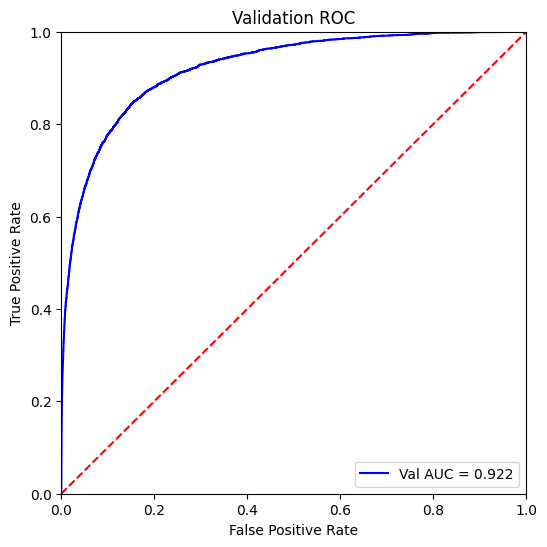

In [ ]:
probabilities, true = get_predictions(val_loader, model, DEVICE)
fpr, tpr, threshold = metrics.roc_curve(true, probabilities)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Model 2 : Results

We did several rounds of model training in the process of **hyperparameter tuning**, I have consolidated them all in an **Excel** file and the link has been shared in **GitHub** as well. This is the screenshot here:

:
<img src="https://github.com/GVworkds/Deep-Learning-Finals/blob/main/Model%20Architecture%202%20Results.png?raw=true">



So on the public leaderboard I got a Kaggle score of **~0.92014** with my best model!

### Step 7 : Generating Submission File

In [ ]:
def get_submission(model, loader, test_ids, device):
    all_preds = []
    model.eval()
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            score = model(x)
            prediction = score.float()
            all_preds += prediction.tolist()

    model.train()

    df = pd.DataFrame({
        "ID_code" : test_ids.values,
        "target" : np.array(all_preds)
    })

    df.to_csv("MySubmission.csv", index=False)

In [ ]:
get_submission(model, test_loader, test_ids, DEVICE)

After doing multiple iterations of hyperparameter tuning, I was able to get these scores on Kaggle Leaderboard as shown below:

<img src="https://github.com/GVworkds/Deep-Learning-Finals/blob/main/Kaggle%20Leaderboard%20Scores%20All.png?raw=true">

If you can see, The submission file 27 was the best so far! It was **92%** which is **pretty awesome on Kaggle Leaderboard**, as it **ranked** somewhere **88 from top**! So we are among the **top 1% on Kaggle** !!!

### Step 8 : Best Kaggle Leaderboard Score

This is the best Kaggle Public Score (**0.92014**) I could get so far:

:

<img src="https://github.com/GVworkds/Deep-Learning-Finals/blob/main/Kaggle%20Leaderboard%20Screenshot%20-%20BEST.png?raw=true">

### Step 9 : Conclusion and Future Work

So we could see that even if we used a very simple architecture of neural networks, a sequential neural network, without much transformations. We could do pretty well only when we added new features to our model with help of some feature engineering. That peice of information turned out very helpful for the model for figuring out whether a customer will make a transaction in future or not! As we could not leverage our domain knowledge in this case because the dataset was **anonymized**. So in that case specifically, we got to do some more **Feature Engineering**, ensembling and so on, to get better results.

Though I did not use **Ensemble** in this project, I am looking forward to it. I am sure it is going to increase my Kaggle Leaderboard score a little bit. But We do see now that **Neural Networks** are so useful models when we have a dataset like a **blackbox**, we know nothing about! It can so beautifully see a pattern which we humans can never figure it out! In the future I might add some new features to our model and see if it further improved the performance.

Like we observed in our EDA that the **var_68** had a peculiar characteristics as compared to the other features. Maybe that could be a date variable. If we could feature engineer that, then we could do some time-series analysis on the training dataset and then come up with a more robust architecture! It all depends on, how do we derive our insights from such kind of dataset which looks like a blackbox in the very beginning! EDA and Feature Engineering are very powerful tools in that case!